# Student Performance

Jade Chen, Prabhjot Singh, Brianna Zhou, Tamara Nammao

![Student Performance](https://github.com/jadeeechen/STAT-301-Project-2023W1-/blob/main/studentperformance.jpg?raw=true)
<br>Source: Youtube - Ma. Israelle S. Lopez

## Introduction

The dataset chosen attest to student performance. The data is taken from two Portuguese secondary schools and collected through school reports and questionnaires. One dataset is about “Mathematics” and the other is about “Portuguese Language”. For our project, we are only using the dataset on “Mathematics”.

In terms of predicting a students final grade (`G3`) we propose the question: Can family background, lifestyle, and study habits predict a student's final grade in Mathematics? We've grouped variables into the categories of family backgrond, lifestyle and student habits with more information on each in the research question section below.

Our dataset had numerous categorical variables with multiple levels, so our approach involved converting these variables into binary variables with 2 levels. This binary transformation facilitated the use of the LASSO tool, allowing us to identify the most crucial variables by shrinking less impactful ones down to zero. While LASSO can pose challenges for categorical variables, treating them as binary variables, as demonstrated in the study by Grill et al. (2012), enables effective utilization of LASSO.

Moreover, LASSO's has to capability for accurate prediction as to manage dimensional datasets, pinpoint significant features, and prevent overfitting by reducing less influential coefficients to zero. This is highlighted in the research by Muthukrishnan and Rohini (2016). This regularization technique not only enhances predictive accuracy but also promotes model simplicity and interpretability making it easier for the reader.

### Source

The original dataset was taken from the following link:
https://archive.ics.uci.edu/dataset/320/student+performance

### Research Question


<span style="color:red"> Can family background, school background, lifestyle, and study habits predict a student's final grade in Mathematics?</span>

- **Response** Variable (Dependent Variable)
    - `G3` (Final Grade)<br><br>

- **Explanatory** Variables (Independent Variables)
    - Family Background:
        - `internet` (Internet Access at Home)
        - `traveltime` (Home to School Travel Time)
    - School Background
        - `school` (Student's School)
        - `schoolsup` (Extra Educational Support)
        - `absences` (Number of School Absences)
        - `failures` (Number of Past Class Failures)
        - `higher` (Wants to Take Higher Education)
    - Lifestyle:
        - `goout` (Going Out)
        - `romantic` (With a Romantic Relationship)
        - `dalc` and `walc` (Alchohol Consumption)
    - Study Habits
        - `studytime` (Weekly Study Time)<br><br>

- Note: There are multiple variables that can be used for our research question, here, it has been narrowed down to the ones we hypothesize are important.

## Methods and Results

#### Importing Packages

In [15]:
library(tidyverse)
library(GGally)
library(patchwork)
library(corrplot)
library(gridExtra)
library(forcats)
library(glmnet)
library(rsample)
library(mltools)

options(warn=-1)  # -1 suppresses all warnings

#### Read Data
Read in data from the web, split by delimiter `;` to have one feature per column, and show the first 3 observations.

In [16]:
url = 'https://raw.githubusercontent.com/jadeeechen/STAT-301-Project-2023W1-/main/student-mat.csv'
data <- read.csv(url, sep = ";")
head(data,3)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,6,5,6,6
2,GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,4,5,5,6
3,GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,10,7,8,10


#### Drop Features

Since we are only interested in the final grade `G3`, we shall drop the first and second period grades `G1` and `G2`.

As noted in the dataset source:
> Important Note: The target attribute `G3` has a strong correlation with attributes `G2` and `G1`. This occurs because `G3` is the final year grade (issued at the 3rd period), while `G1` and `G2` correspond to the 1st and 2nd period grades. It is more difficult to predict `G3` without `G1` and `G2`, but such prediction is much more useful (see paper source for more details).

In [17]:
data <- data |>
    select(-G1, -G2)

#### Data Wrangling
Most of the data do not have the correct type. The relevant features were converted to numeric/factor type according to the "Additional Variable Information" from the dataset source.

In [18]:
#Binary -> Factor Type
data$school <- as.factor(data$school)
data$sex <- as.factor(data$sex)
data$address <- as.factor(data$address)
data$famsize <- as.factor(data$famsize)
data$Pstatus <- as.factor(data$Pstatus)
data$schoolsup <- as.factor(data$schoolsup)
data$famsup <- as.factor(data$famsup)
data$paid <- as.factor(data$paid)
data$activities <- as.factor(data$activities)
data$nursery <- as.factor(data$nursery)
data$higher <- as.factor(data$higher)
data$internet <- as.factor(data$internet)
data$romantic <- as.factor(data$romantic)

#Nominal -> Factor Type
data$Mjob <- as.factor(data$Mjob)
data$Fjob <- as.factor(data$Fjob)
data$reason <- as.factor(data$reason)
data$guardian <- as.factor(data$guardian)

#Numeric -> Numeric Type
data$age <- as.numeric(data$age)
data$Medu <- as.numeric(data$Medu)
data$Fedu <- as.numeric(data$Fedu)
data$traveltime <- as.numeric(data$traveltime)
data$studytime <- as.numeric(data$studytime)
data$failures <- as.numeric(data$failures)
data$famrel <- as.numeric(data$famrel)
data$freetime <- as.numeric(data$freetime)
data$goout <- as.numeric(data$goout)
data$Dalc <- as.numeric(data$Dalc)
data$Walc <- as.numeric(data$Walc)
data$health <- as.numeric(data$health)
data$absences <- as.numeric(data$absences)
data$G3 <- as.numeric(data$G3)

#### Feature Details
We have the detailed description for possible values of each 33 features.

1. `school`: Student's School
    - GP - Gabriel Pereira
    - MS - Mousinho da Silveira
2. `sex`: Student's Sex
    - F - female
    - M - male
3. `age`: Student's Age
    - from 15 to 22
4. `address`: Student's Home Address Type
    - U - urban
    - R - rural
5. `famsize`: Family Size
    - LE3 - less or equal to 3
    - GT3 - greater than 3
6. `pstatus`: Parent's Cohabitation Status
    - T - living together
    - A - apart
7. `medu`: Mother's Education
    - 0 - none
    - 1 - primary education (4th grade)
    - 2 – 5th to 9th grade
    - 3 – secondary education
    - 4 – higher education
8. `fedu`: Father's Education
    - 0 - none
    - 1 - primary education (4th grade)
    - 2 – 5th to 9th grade
    - 3 – secondary education
    - 4 – higher education
9. `mjob`: Mother's Job
    - teacher
    - health - health care related
    - services - civil services (e.g. administrative or police)
    - at_home
    - other
10. `fjob`: Father's Job
    - teacher
    - health - health care related
    - services - civil services (e.g. administrative or police)
    - at_home
    - other
11. `reason`: Reason to Choose This School
    - home - close to home
    - reputation - school reputation
    - course - course preference
    - other
12. `guardian`: Student's Guardian
    - mother
    - father
    - other
13. `traveltime`: Home to School Travel Time
    - 1 - <15 min.
    - 2 - 15 to 30 min.
    - 3 - 30 min. to 1 hour
    - 4 - >1 hour
14. `studytime`: Weekly Study Time
    - 1 - <2 hours
    - 2 - 2 to 5 hours
    - 3 - 5 to 10 hours
    - 4 - >10 hours
15. `failures`: Number of Past Class Failures
    - n if: 1 <= n < 3
    - else: 4
16. `schoolsup`: Extra Educational Support
    - yes
    - no
17. `famsup`: Family Educational Support
    - yes
    - no
18. `paid`: Extra Paid Classes within the Course Subject
    - yes
    - no
19. `activities`: Extra-Curricular Activities
    - yes
    - no
20. `nursery`: Attended Nursery School
    - yes
    - no
21. `higher`: Wants to Take Higher Education
    - yes
    - no
22. `internet`: Internet Access at Home
    - yes
    - no
23. `romantic`: With a Romantic Relationship
    - yes
    - no
24. `famrel`: Quality of Family Relationships
    - 1 (very bad) to 5 (excellent)
25. `freetime`: Free Time After School
    - 1 (very low) to 5 (very high)
26. `goout`: Going Out with Friends
    - 1 (very low) to 5 (very high)
27. `dalc`: Workday Alcohol Consumption
    - 1 (very low) to 5 (very high)
28. `walc`: Weekend Alcohol Consumption
    - 1 (very low) to 5 (very high)
29. `health`: Current Health Status
    - 1 (very bad) to 5 (very good)
30. `absences`: Number of School Absences
    - 0 to 93
31. `g1`: First Period Grade
    - 0 to 20
32. `g2`: Second Period Grade
    - 0 to 20
33. `g3`: Final Grade
    - 0 to 20

###  Exploratory Data Analysis

We will first conduct some EDA, then we will create a final visualization suitable to answer our research question.

#### Summary Statistics for Numerical Data Analysis
We observe the data's central tendencies, spread, and shape to understand the data's overall structure for numerical variables.

In [19]:
numeric_vars <- c("age", "Medu", "Fedu", "traveltime", "studytime", "failures", 
                  "famrel", "freetime", "goout", "Dalc", "Walc", "health", 
                  "absences", "G3")

categorical_vars <- c("school", "sex", "address", "famsize", "Pstatus", 
                      "Mjob", "Fjob", "reason", "guardian", "schoolsup", 
                      "famsup", "paid", "activities", "nursery", "higher", 
                      "internet", "romantic")

In [20]:
summary_stats <- summary(data[numeric_vars])
print(summary_stats)

      age            Medu            Fedu         traveltime      studytime    
 Min.   :15.0   Min.   :0.000   Min.   :0.000   Min.   :1.000   Min.   :1.000  
 1st Qu.:16.0   1st Qu.:2.000   1st Qu.:2.000   1st Qu.:1.000   1st Qu.:1.000  
 Median :17.0   Median :3.000   Median :2.000   Median :1.000   Median :2.000  
 Mean   :16.7   Mean   :2.749   Mean   :2.522   Mean   :1.448   Mean   :2.035  
 3rd Qu.:18.0   3rd Qu.:4.000   3rd Qu.:3.000   3rd Qu.:2.000   3rd Qu.:2.000  
 Max.   :22.0   Max.   :4.000   Max.   :4.000   Max.   :4.000   Max.   :4.000  
    failures          famrel         freetime         goout      
 Min.   :0.0000   Min.   :1.000   Min.   :1.000   Min.   :1.000  
 1st Qu.:0.0000   1st Qu.:4.000   1st Qu.:3.000   1st Qu.:2.000  
 Median :0.0000   Median :4.000   Median :3.000   Median :3.000  
 Mean   :0.3342   Mean   :3.944   Mean   :3.235   Mean   :3.109  
 3rd Qu.:0.0000   3rd Qu.:5.000   3rd Qu.:4.000   3rd Qu.:4.000  
 Max.   :3.0000   Max.   :5.000   Max.   :5.

Table 1

#### Frequency Table for Categorical data analysis

In [21]:
for(var in categorical_vars) {
  freq_table <- table(data[[var]])
  print(paste("Frequency table for", var))
  print(freq_table)
}

[1] "Frequency table for school"

 GP  MS 
349  46 
[1] "Frequency table for sex"

  F   M 
208 187 
[1] "Frequency table for address"

  R   U 
 88 307 
[1] "Frequency table for famsize"

GT3 LE3 
281 114 
[1] "Frequency table for Pstatus"

  A   T 
 41 354 
[1] "Frequency table for Mjob"

 at_home   health    other services  teacher 
      59       34      141      103       58 
[1] "Frequency table for Fjob"

 at_home   health    other services  teacher 
      20       18      217      111       29 
[1] "Frequency table for reason"

    course       home      other reputation 
       145        109         36        105 
[1] "Frequency table for guardian"

father mother  other 
    90    273     32 
[1] "Frequency table for schoolsup"

 no yes 
344  51 
[1] "Frequency table for famsup"

 no yes 
153 242 
[1] "Frequency table for paid"

 no yes 
214 181 
[1] "Frequency table for activities"

 no yes 
194 201 
[1] "Frequency table for nursery"

 no yes 
 81 314 
[1] "Frequency table f

Table 2




***Interpretation***




1. **`school` Distribution**: The dataset primarily contains students from the `gp` (Gabriel Pereira) school, with only a smaller representation from the `ms` (Mousinho da Silveira) school.

2. **`gender` Distribution**: There are more female students (`f`) in the dataset than male students (`m`).

3. **`age` Range**: The age of students in the dataset ranges from 15 to 22, with a median age of 17 years.

4. **`address` Distribution**: Most students live in urban areas (`u`), while a smaller percentage lives in rural areas (`r`).

5. **`family_size`**: The majority of students come from families with more than three members (`gt3`). A smaller portion comes from families with three or fewer members (`le3`).

6. **`pstatus`**: Most students have parents who live together (`t`), while a smaller group has parents who live apart (`a`).

7. **`medu` and `fedu`**: Parental education levels (`medu` and `fedu`) vary, with the majority falling in the middle range (2-3 on a scale of 0-4).

8. **`traveltime`**: The travel time to school (`traveltime`) is generally short, with a range from 1 to 4.

9. **`studytime`**: Study time (`studytime`) ranges from 1 to 4, with a relatively balanced distribution.

10. **`failures` History**: Most students have a history of few or no past class failures (`failures` range from 0 to 3).

11. **`famsup`**: There is a balanced distribution of students with or without family support (`famsup`).

12. **`paid` Classes**: A portion of students receives extra paid classes within the course (`paid`: `yes`).

13. **`activities`**: A portion of students participates in extracurricular activities (`activities`: `yes`).

14. **`nursery` Attendance**: Most students attended nursery school (`nursery`: `yes`).

15. **`higher` Desire for Higher Education**: The majority of students express a desire to pursue higher education (`higher`: `yes`).

16. **`internet` Access**: A significant portion of students has internet access at home (`internet`: `yes`).

17. **`romantic` Relationships**: A subset of students is in romantic relationships (`romantic`: `yes`).

18. **`famrel` Relationships**: Family relationships are generally rated positively, with a median score of 4 on a scale of 1 to 5.

19. **`freetime` Free Time**: Students generally have moderate amounts of free time.

20. **`goout` Socializing**: Students have a range of socializing levels.

21. **`dalc` and `walc` Alcohol Consumption**: Alcohol consumption varies but is generally moderate.

22. **`health` Status**: Most students report moderate to good health status.

23. **`absences`**: Absences range from 0 to 75, with a mean of approximately 5.7.

24. **`g3` Final Grades**: The final grades (`g3`) vary from 0 to 20, with a mean of approximately 10.4.

#### Box Plots

We use a box plot to examine the relationship between internet access `internet` and final grade `G3`, according to the research question.

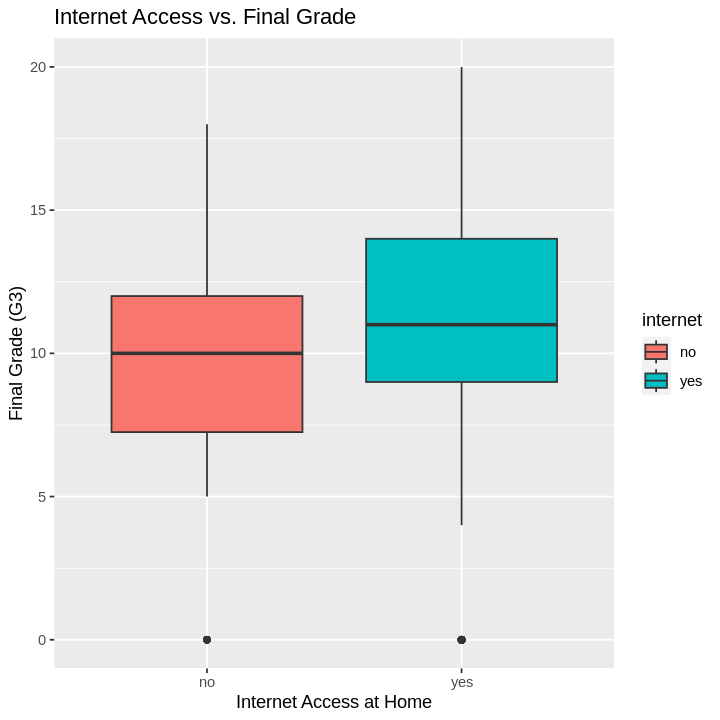

In [22]:
options(repr.plot.width=6, repr.plot.height=6)
box_internet <- ggplot(data, aes(x = internet, y = G3, fill = internet)) +
    geom_boxplot() +
    labs(x = "Internet Access at Home", y = "Final Grade (G3)") +
    ggtitle("Internet Access vs. Final Grade")
box_internet

Figure 1

**Interpretation**

1. **Central Tendency:**: All three quartiles (lower, middle, upper) are slightly higher for the group with internet access compared to the group without internet access. This indicates that, on average, students with internet access have higher final grades across the board.
2. **Spread of Data:**: The lower whisker for the group with internet access is longer, this indicates that there is a wider range of lower final grades in the group with internet access compared to the group without internet access. The upper whiskers are the same for both groups, this suggests that the upper range of final grades is similar for students with and without internet access. The highest final grades achieved by students in both groups are comparable.
3. **Outliers:**: Both groups have a dot for outliers at the same location (`0`) of the final grade, indicating that there are data points in both groups with exceptionally low final grades. This suggests that certain students from both groups face similar academic challenges, or perhaps they missed school due to extenuating circumstances.

In summary, the box plot reveals that students with internet access, on average, perform better in terms of final grades, but there is more variation in lower grades within this group. It also highlights that both groups share similar academic challenges, as indicated by the presence of outliers with exceptionally low final grades.

#### Faceted Bar Chart

Next, we shall use faceted bar charts to examine the distribution of our numeric response variable `G3` (using the average), and how it varies across **factor** and **numeric** variables in order to identify trends, patterns, and differences in the data.

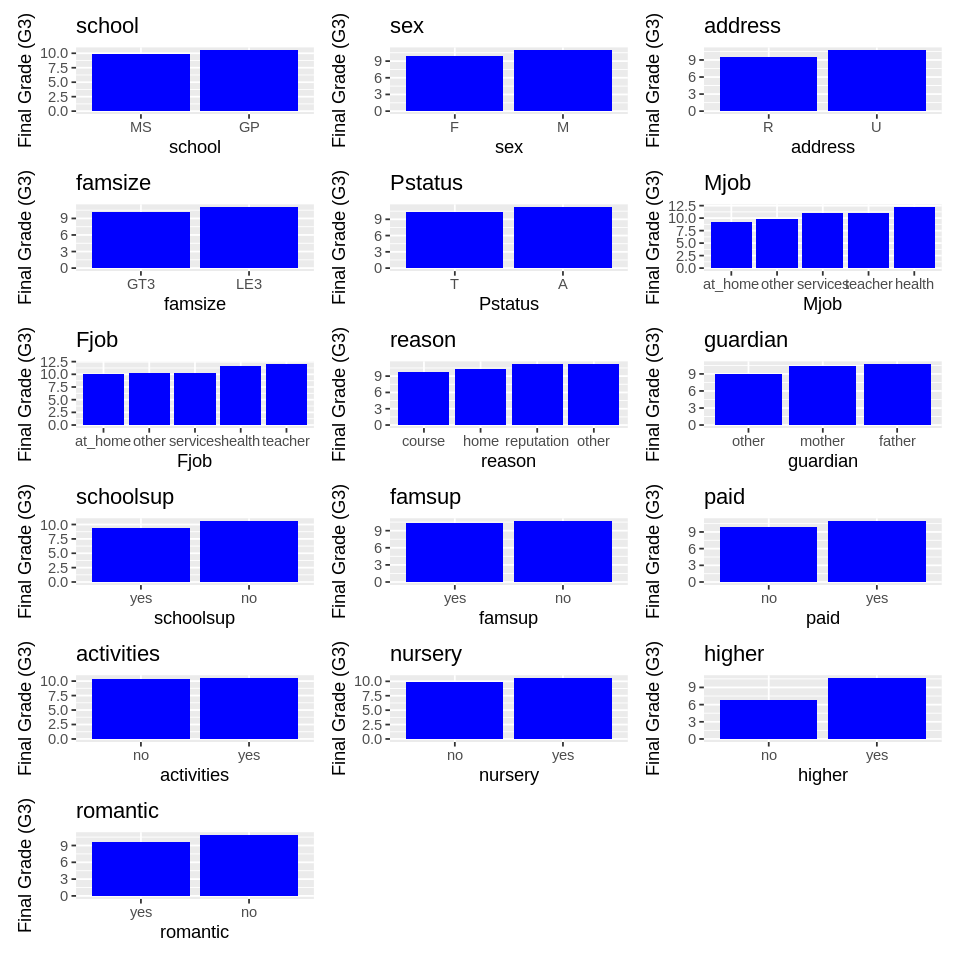

In [23]:
options(repr.plot.width=8, repr.plot.height=8)

############## FACTOR ############## 

#Remove Internet because already explored
data_factor <- data |>
    select_if(is.factor) |>
    select(-internet)

# Define the variable names for faceting
facet_vars_factor <- colnames(data_factor)

# Create a list of ggplot objects for each facet
facetbar_factor <- lapply(facet_vars_factor, function(var) {
    average_data <- data |>
        group_by(.data[[var]]) |>
        summarize(avg_G3 = mean(G3, na.rm = TRUE)) |>
        arrange(desc(avg_G3)) |>
        mutate(!!var := reorder(.data[[var]], avg_G3)) #  Re-arrange the factor levels so that they are ordered by the values of avg_G3
    
    ggplot(average_data, aes(x = .data[[var]], y = avg_G3)) +
    geom_bar(stat = "identity", fill = "blue") +
    labs(x = var, y = "Final Grade (G3)") +
    ggtitle(var)
})

# Combine the plots
plot_facetbar_factor <- wrap_plots(facetbar_factor, ncol = 3)
plot_facetbar_factor

Figure 2

**Interpretation**

*On average*,

1. `School`: Those from the school Gabriel Pereira `GP` have a higher final grade.
2. `Sex`: Males `M` have a higher final grade.
3. `Address`: Those who live in urban parts `U`, have a higher final grade.
4. `FamilySize`: Those from family sizes less than 3 `LE3` have a higher final grade.
5. `PStatus`: Those with parents that live apart `A` have a higher final grade.
6. `MJob`: Those with fathers working in health care related jobs `health` have a higher final grade.
7. `FJob`: Those with mothers working in education `teacher` have a higher final grade.
8. `Reason`: Those that chose their school due to school reputation `reputation` and other reasons `other` have a higher final grade (comparable).
9. `Guardian`: Those whose guardian are their fathers `father` or mothers `mother` have a higher final grade than those with other types `other`.
10. `SchoolSupport`: Those without extra educational support `no` have a higher final grade.
11. `FamSupport`: Those without family educational support `no` have a higher final grade.
12. `Paid`: Those with extra paid classes within the course subject `yes` have a higher final grade.
13. `Activities`: Those who do `yes` an do not engage `no` in extra-curricular activities have no observable difference in final grades.
14. `Nursery`: Those that attended nursery school `yes` have a slightly higher final grade.
15. `Higher`: Those that want to take higher education `yes` have an observably higher final grade.
16. `Romantic`: Those with a romantic relationship `yes` have a lower final grade.

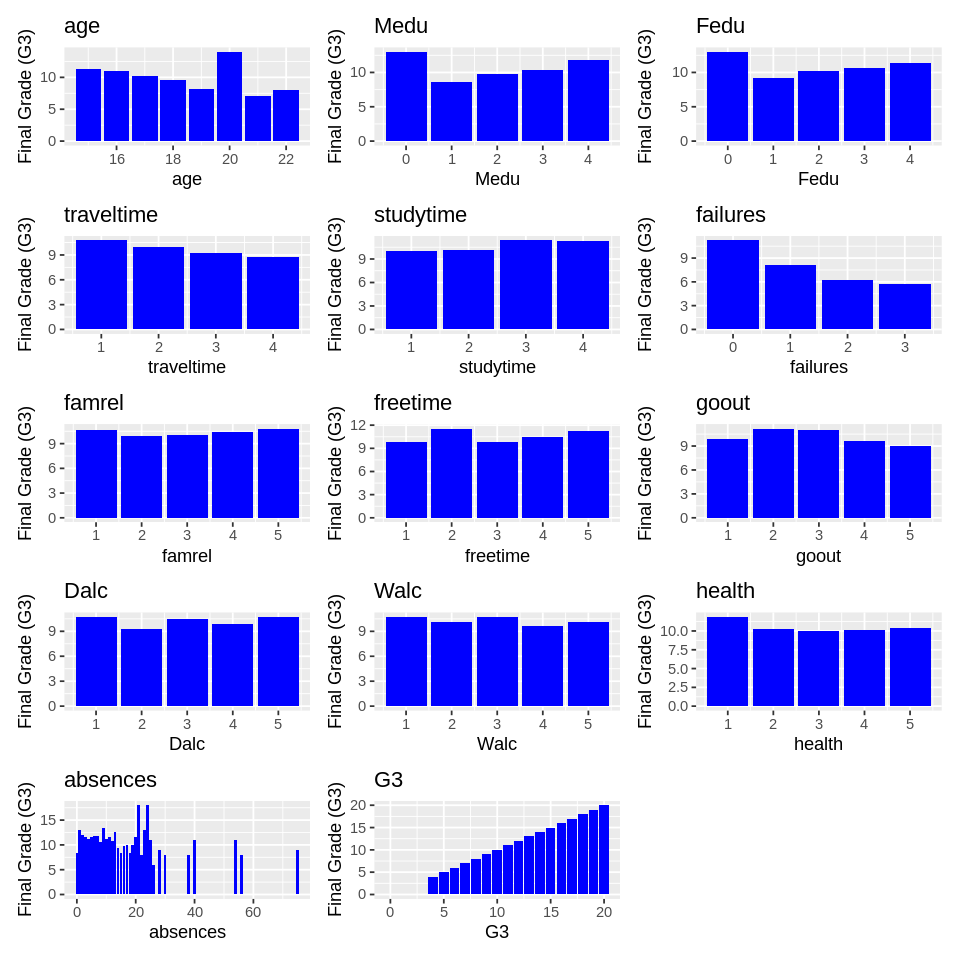

In [24]:
############## NUMERIC ############## 

options(repr.plot.width=8, repr.plot.height=8)

data_numeric <- data |>
    select_if(is.numeric)

# Define the variable names for faceting
facet_vars_numeric <- colnames(data_numeric)

# Create a list of ggplot objects for each facet
facetbar_numeric <- lapply(facet_vars_numeric, function(var) {
    average_data <- data |>
        group_by(.data[[var]]) |>
        summarize(avg_G3 = mean(G3, na.rm = TRUE))
    
    ggplot(average_data, aes(x = .data[[var]], y = avg_G3)) +
    geom_bar(stat = "identity", fill = "blue") +
    labs(x = var, y = "Final Grade (G3)") +
    ggtitle(var)
})

# Combine the plots
plot_facetbar_numeric <- wrap_plots(facetbar_numeric, ncol = 3)
plot_facetbar_numeric

Figure 3

**Interpretation**

*On average*,

1. `Age`: Those of age `20` have the highest final grade.
2. `MEdu`: Those whose mother's don't have higher education have the highest grade. However, as the mother's education increases, the students final grade increases.
3. `FEdu`: Same with father's education.
4. `TravelTime`: As the home to school travel time increases, the final grade decreases.
5. `StudyTime`: As study time increases, final grade increases. However, once the study time is more than 10 hours, there is no observable increase.
6. `Failures`: As number of past class failures increase, the final grade decreases.
7. `FamRel`: Those with extremely high or extremely low quality of family relationships tend to have higher final grades.
8. `FreeTime`: There is no observable trend in regards to free time after school.
9. `GoOut`: Those that spend an extremely high or extremely low amount of time going out with friends tend to have lower final grades.
10. `DAlch`: There is no observable trend in regards to workday alchohol consumption.
11. `WAlch`: There is no observable trend in regards to weekend alchohol consumption.
12. `Health`: Those with very bad health status tend to have a higher final grade.
13. `Absences`: Those with around 20 absences tend to have the highest final grades.

It's important to note that these observations are based on averages and may not necessarily imply causation. Further analysis and exploration are needed to understand the underlying reasons behind these patterns and differences in the dataset.

#### Correlation Plot

Here we are using a correlation plot to explore the relationship between the **numerical** variables.

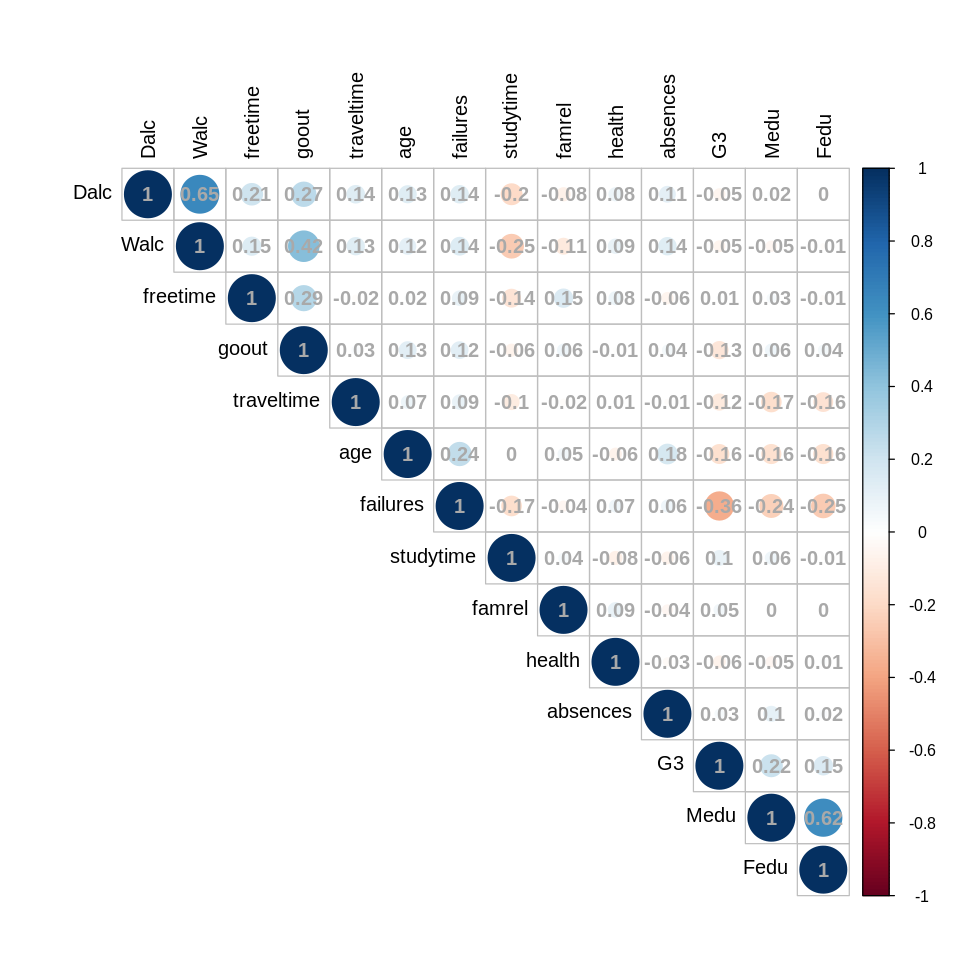

In [25]:
cor_matrix <- cor(data_numeric)

options(repr.plot.width=8, repr.plot.height=8)
corrplot(cor_matrix, method = "circle", type = "upper", order = "hclust", tl.col = "black", addCoef.col = "dark grey")


Figure 4

**Interpretation**

This correlation plot provides a visual representation of the pairwise relationships between different numeric variables related to student performance. Each cell in the plot shows the correlation coefficient between two variables, ranging from -1 to 1, where 1 indicates a perfect positive correlation, -1 indicates a perfect negative correlation, and 0 indicates no correlation.

The color and size of the circles represent the strength and direction of the correlation. Darker blue indicates a stronger positive correlation, and darker red indicates a stronger negative correlation. For example, the variables `Medu` (mother's education level) and `Fedu` (father's education level) have a strong positive correlation of 0.62, suggesting that they tend to increase together; as one parent's education level is higher, it's likely the other's is too. It is essential to be mindful of the presence of **multicollinearity**, particularly in the cases of `Dalc` between `Walc`, and `Medu` between `Fedu`. Their strong positive correlation may result in difficulties when interpreting their individual impacts in regression models later on. We should consider addressing multicollinearity through variable selection to ensure the reliability and interpretability of our analysis later on. 

There are notable correlations with the `G3` variable, which represents the final grade. `failures` has a significant negative correlation (-0.36) with `G3`, indicating that students with more failures tend to have lower final grades. `studytime` shows a small positive correlation with `G3` (0.1), suggesting that more study time might be associated with higher final grades, although the relationship is weak.

The plot also reveals that some variables do not have a strong relationship with `G3`, such as `traveltime`, `age`, and `health`, as indicated by their correlation coefficients being close to 0 with the final grade. This suggests that these factors might not be strong predictors of the final grade on their own.



#### Visualizations

After we've used multiple visualizations to perform EDA, we conclude that the following visualizations are most relevent to address the research question.

##### Visualization 1

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]

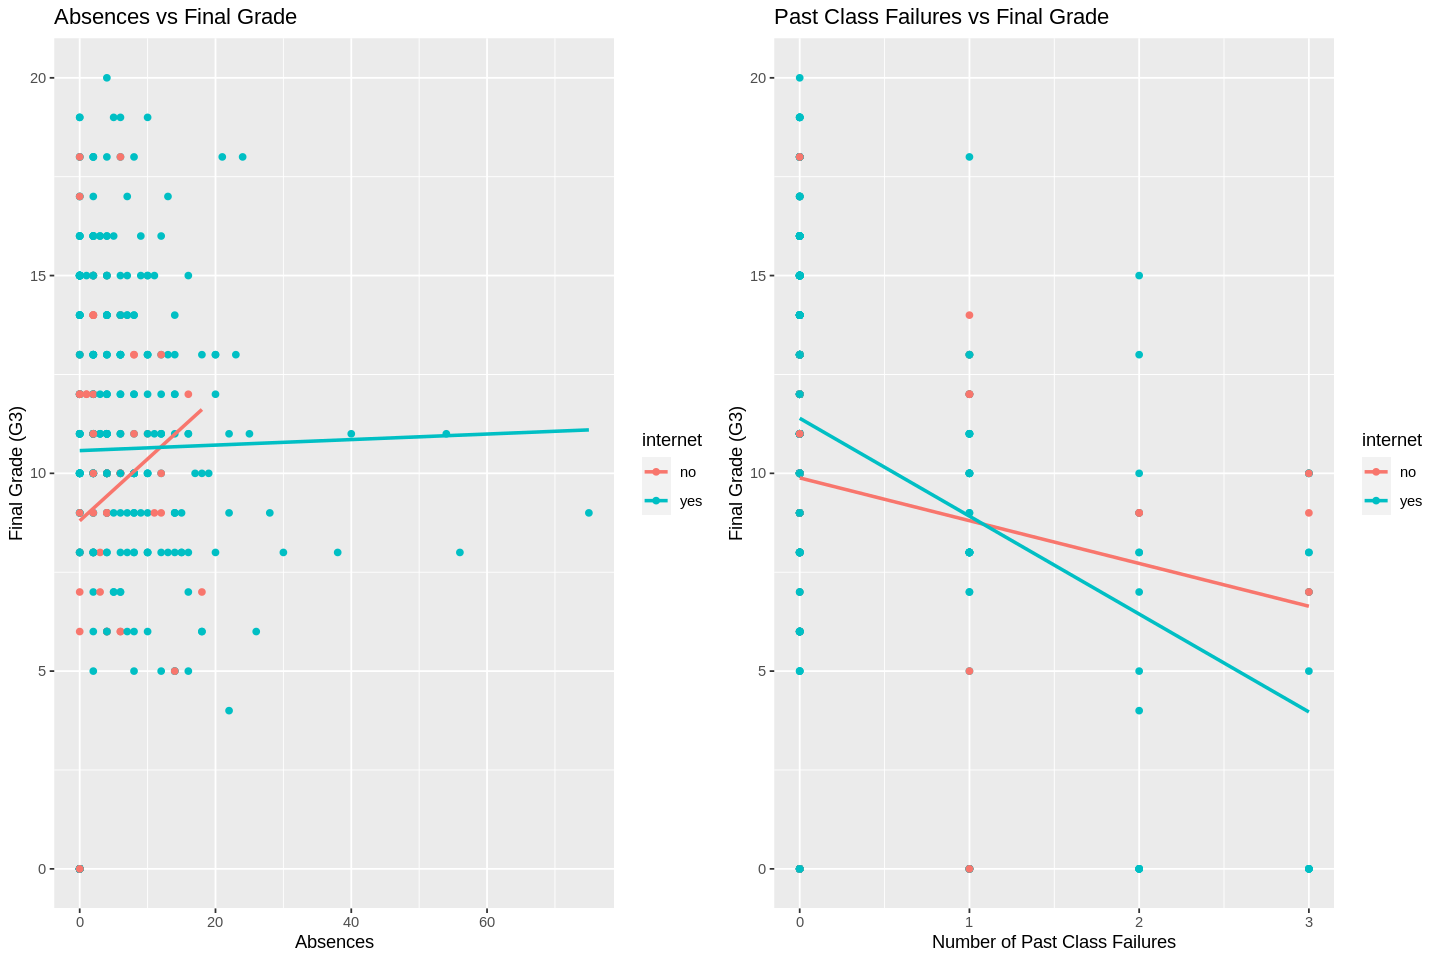

In [26]:
options(repr.plot.width=12, repr.plot.height=8)
scatter_absences_combined <- ggplot(data, aes(x = absences, y = G3, color = internet)) +
  geom_point() +
  labs(x = "Absences", y = "Final Grade (G3)", 
       title = "Absences vs Final Grade") +
  geom_smooth(method = "lm", se = FALSE)

scatter_failures_combined <- ggplot(data, aes(x = failures, y = G3, color = internet)) +
  geom_point() +
  labs(x = "Number of Past Class Failures", y = "Final Grade (G3)", 
       title = "Past Class Failures vs Final Grade") +
  geom_smooth(method = "lm", se = FALSE)

combined_plot <- grid.arrange(scatter_absences_combined, scatter_failures_combined, ncol = 2)

combined_plot

Figure 5

#### Reason for Plot Choice

1. **Comparative Analysis**: We can assess how two factors `Failures` `Absences` individually relate to the final grade `G3` and whether one appears to have a more pronounced effect than the other.

2. **Interaction Assessment**: We can examine whether the influence of absences and past class failures on final grades varies depending on whether students have internet access at home `Internet`.

3. **Prediction and Inference**: The linear regression lines in each plot provide a basis for prediction and inference. We can observe the trend and slope of the lines to make predictions about final grades based on absences and past class failures while accounting for internet access at home.

In summary, this combined plot provides a powerful visual tool for investigating the research question, exploring interactions between variables, and making predictions.

#### Potential Challenges

- **Multicollinearity**: As mentioned earlier, we should be cautious about multicollinearity, which arises when dummy variables are highly correlated, potentially causing issues in the model's interpretability and leading to unstable coefficient estimates.

- **Imbalanced Groups**: From the interpretations we derived from the previous summary statistics, some the distribution is not balanced across groups (e.g. `School` and `Gender`), this may to biased prediction results later on.

Further challenges may appear during the third stage: Methods and Plan.

##### Visualization 2

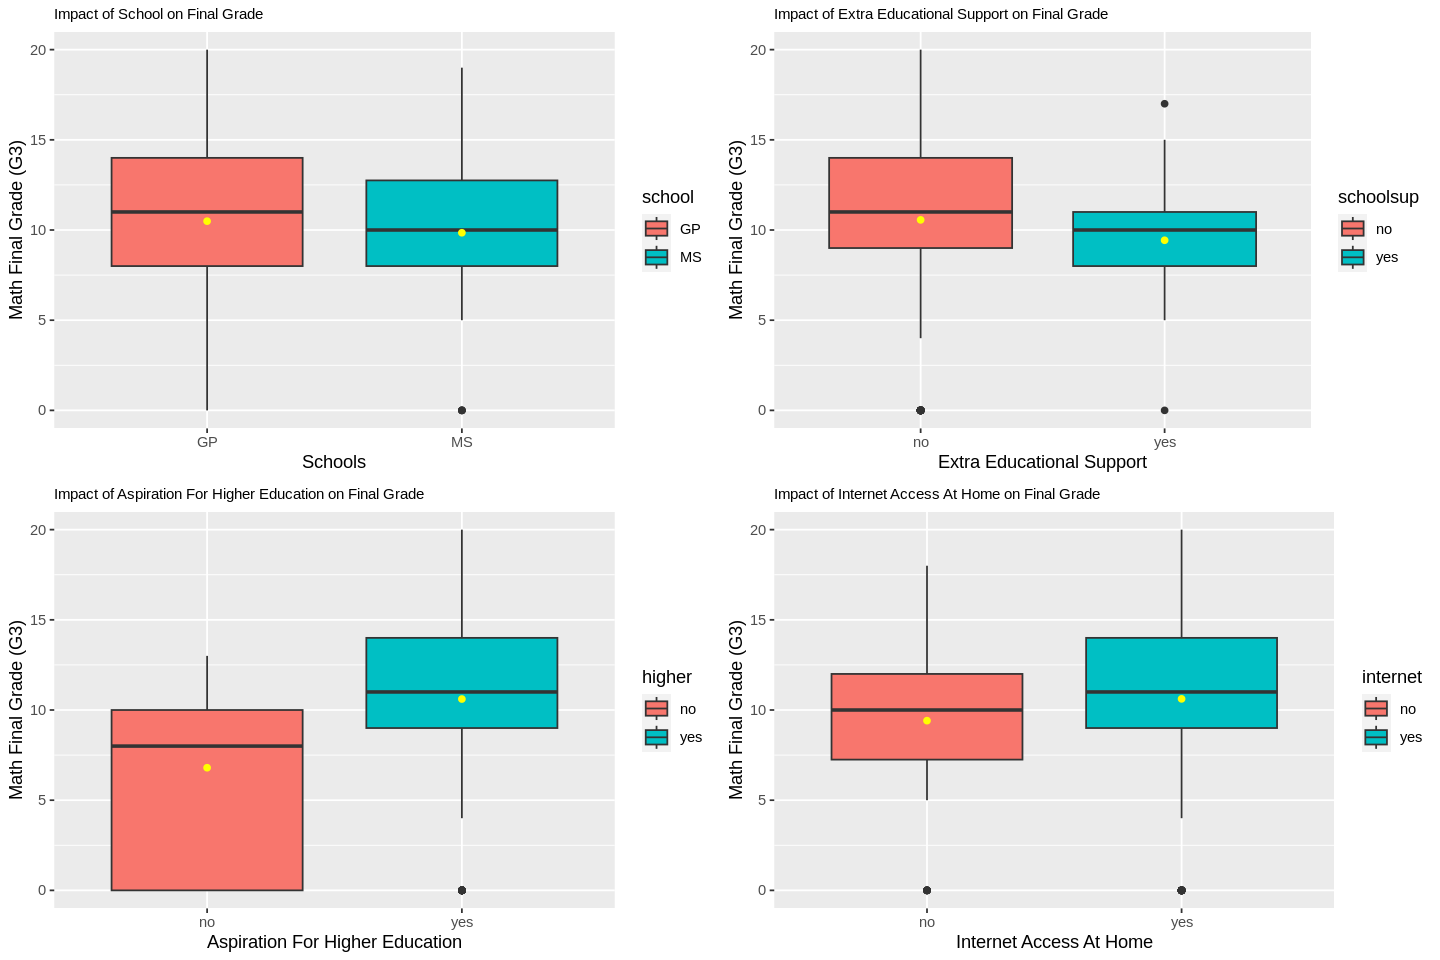

In [27]:
# Create a boxplot of math grades based on the school ('GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)
mat_boxplot_school <- data |>
        ggplot(aes(x = school, y = G3, fill = school)) +
        geom_boxplot() +
        stat_summary(fun=mean, geom='point',color="yellow", fill="yellow") +
        labs(x = "Schools", y = "Math Final Grade (G3)", 
        title = "Impact of School on Final Grade") +
        theme(plot.title = element_text(size = 9))

# Create a boxplot of math grades based on extra educational support 
mat_boxplot_schoolsup <- data |>
        ggplot(aes(x = schoolsup, y = G3, fill = schoolsup)) +
        geom_boxplot() +
        stat_summary(fun=mean, geom='point', color="yellow", fill="yellow") +
        labs(x = "Extra Educational Support", y = "Math Final Grade (G3)", 
        title = "Impact of Extra Educational Support on Final Grade")+
        theme(plot.title = element_text(size = 9))

# Create a boxplot of math grades based on aspiration to take higher education 
mat_boxplot_higher <- data |>
        ggplot(aes(x = higher, y = G3, fill = higher)) +
        geom_boxplot() +
        stat_summary(fun=mean, geom='point', color="yellow", fill="yellow") +
        labs(x = "Aspiration For Higher Education", y = "Math Final Grade (G3)", 
        title = "Impact of Aspiration For Higher Education on Final Grade") +
        theme(plot.title = element_text(size = 9))

# Create a boxplot of math grades based on Internet access at home
mat_boxplot_internet <- data |>
        ggplot(aes(x = internet, y = G3, fill = internet)) +
        geom_boxplot() +
        stat_summary(fun=mean, geom='point', color="yellow", fill="yellow") +
        labs(x = "Internet Access At Home", y = "Math Final Grade (G3)", 
        title = "Impact of Internet Access At Home on Final Grade") +
        theme(plot.title = element_text(size = 9))

combine_plot1 <- grid.arrange(mat_boxplot_school , mat_boxplot_schoolsup, mat_boxplot_higher, 
                              mat_boxplot_internet, ncol = 2)

Figure 6

 **Interpretation of the visualization**
 
The combination of boxplots reveals how various factors relate to students' final grades (`G3`). The boxplot examine distinct varaibles like school type (`school`), availability of extra educational support (`schoolsup`), aspiration for higher education (`higher`), and internet access at home (`internet`). Each boxplot reveals differences in mean final grades between different categories of these factors, which illustrates students in 'GP' (Gabriel Pereira) school, those without extra educational support, aiming for higher eduaction, and with internet access at home have higher mean final grades. 

##### Visualization 3

[1] 0.03570681


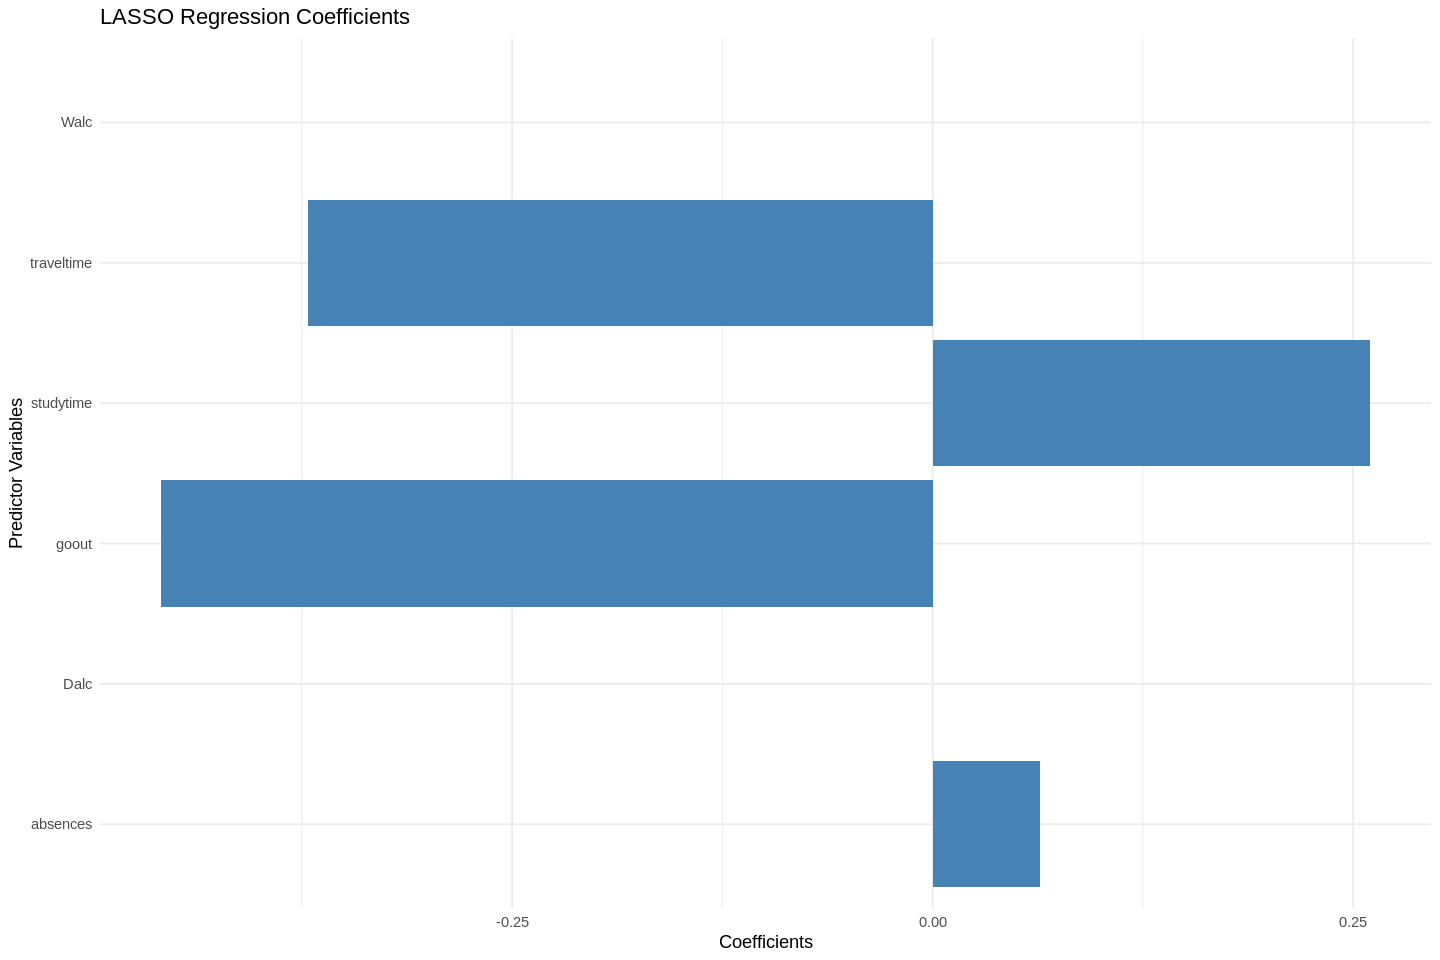

In [28]:
explanatory_vars <- c("studytime", "traveltime", "goout", "Dalc", "Walc", "absences")
response_var <- "G3"

data_for_model <- data[, c(explanatory_vars, response_var)]

# Create model matrix for LASSO regression
x <- model.matrix(G3 ~ ., data_for_model)[, -1] 
y <- data$G3

# Scale the explanatory variables
x_scaled <- scale(x)


set.seed(123) 

cv_lasso <- cv.glmnet(x_scaled, y, alpha = 1)  # alpha=1 for LASSO

# Extract the best lambda value
best_lambda <- cv_lasso$lambda.min

# Fit the LASSO model with the best lambda value
lasso_model <- glmnet(x_scaled, y, alpha = 1, lambda = best_lambda)

# Extract coefficients from the LASSO model
lasso_coef <- coef(lasso_model, s = best_lambda)

# Predict values using the LASSO model
predicted_values <- predict(lasso_model, s = best_lambda, newx = x_scaled)

# Calculate R-squared value
r_squared <- 1 - sum((y - predicted_values)^2) / sum((y - mean(y))^2)

# Print R-squared value
print(r_squared)

# Convert the LASSO coefficients to a dataframe for plotting
coef_df <- data.frame(
  Variable = rownames(lasso_coef),
  Coefficient = lasso_coef[, 1]
)

# Remove the intercept row for plotting
coef_df <- coef_df[-1, ]

# Visualization
ggplot(coef_df, aes(x = Variable, y = Coefficient)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +  # Flips the axes for easier reading
  theme_minimal() +
  labs(title = "LASSO Regression Coefficients",
       x = "Predictor Variables",
       y = "Coefficients")

Figure 7

### Methods: Plan

#### Method: Lasso Regularization

1. **Feature Engineering: Dichotomization** Merge categorical featurs with 3+ levels so they become binary factors.

2. **Dummy Variables:** Create dummy variables for the categorical variables.
   
3. **Variable Selection:** Use <span style="color:red">Lasso</span> regression for variable selection, and find optimal value of $\lambda$ with cross-validation.

4. **Model Building:** Utilize multiple linear regression `lm`.

5. **Evaluation & Results:** Evaluate the model's performance using relevant metrics (e.g. $MSE$).

#### Reason

1. **High-Dimensional Data:** Our datset includes a large amount of variables which can lead to a high-dimensional feature space. Lasso can perform variable selection by shrinking some coefficients to zero.

2. **Interpretability:** We are interested in determining which factors (among family background, number of failures, and number of absences) are significant predictors of a student's final grade. Lasso's feature selection can help identify the most relevant variables.
   
3. **Preventing Overfitting:** Lasso introduces a penalty term that helps prevent overfitting by regularizing the model.

4. **Dealing with Correlated Predictors:** As seen in the EDA, there is the presence of multicollinearity. Lasso can handle multicollinearity issues by automatically selecting one variable over the others. Thus, we no longer need to use variance inflation factors (VIF) because we can rely on Lasso's inherent feature selection capabilities.

#### Assumptions

1. **Linearity:** LASSO assumes a linear relationship between predictors and the response variable, which can be seen in our EDA.

2. **Handling Categorical Variables:** Effective application of Lasso requires addressing factor variables with more than three levels, as Lasso's feature selection may lead to issues related to the omitted category.
   - **Solution:** Employ domain knowledge to merge different factor levels to transform them into binary factors, creating only 1 dummy variable. After feature selection, revert the factors to their original levels if Lasso deems them highly important before applying `lm`.<br><br>

3. **Sensitivity to Scale:** Lasso is sensitive to variable scales, favoring variables with larger scales due to their larger coefficient magnitudes.
   - **Solution:** Before applying Lasso, standardize the variables to ensure a consistent scale to promote fair consideration of all variables.

#### Potential Limitations

1. **Biased Estimators:**: LASSO's aggressiveness in shrinking coefficients can lead to underestimation or overestimation of the true coefficients, introducing bias in the parameter estimates.
    - **Solution (Post-Lasso):** Use the variables selected by Lasso and then fit a regular least squares (LS) regression on these variables, known as "post-lasso."<br><br>

2. **Problem in Prediction:** Fitting a least squares regression after Lasso using the same data for both variable selection and prediction can lead to overfitting (when the penalty is too high). This can lead to inability to generalize well to new, unseen data.
    - **Solution (Data Splitting for Prediction):** Split the dataset into two parts: one for variable selection using Lasso and another for model evaluation and prediction. By employing different subsets of data for these two steps, we can reduce the risk of overestimating the model's performance on the training data and enhance its ability to make accurate predictions on new, unseen observations.

#### Implementation

***1. Feature Engineering***

Dichotomization: Merge categorical featurs with 3+ levels so they become binary factors.
1. `MJob`: Merge `at_home` into `other` and `health`/`teacher` into `services`.
2. `FJob`: Merge `at_home` into `other` and `health`/`teacher` into `services`.
3. `Reason`: Merge `course` and `reputation` into `school_attribute`, and `home` into `other`.
3. `Guardian`: Merge `father` and `mother` into `parents`.

In [29]:
#  MJob and FJob: Merge at_home into other and health/teacher into services.
data$Mjob <- recode_factor(data$Mjob, at_home = "other", health = "services", teacher = "services")
data$Fjob <- recode_factor(data$Mjob, at_home = "other", health = "services", teacher = "services")

# Reason: Merge course and reputation into school_attribute, and home into other.
data$reason <- recode_factor(data$reason, course = "school attribute", reputation = "school attribute", home = "other")

# Guardian: Merge father and mother into parents.
data$guardian <- recode_factor(data$guardian, father = "parents", mother = "parents")

***2. Dummy Variables***

Create dummy variables for the categorical variables.

In [30]:
binary <- c("schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic")

for (column_name in binary) {
  data[[column_name]] <- as.numeric(data[[column_name]] == "yes")
}

In [31]:
factor_2_level <- c("school", "sex", "address", "famsize", "Pstatus", "Mjob", "Fjob", "reason", "guardian")

# Convert factor columns to numeric (1 for the first level, 2 for the second level)
for (column_name in factor_2_level) {
  levels <- levels(data[[column_name]])
  data[[column_name]] <- as.numeric(data[[column_name]] == levels[1]) + 1
}

***3. Variable Selection***

Use <span style="color:red">Lasso</span> regression for variable selection, find optimal value of $\lambda$ with cross-validation, and obtain optimal features for model.

In [32]:
set.seed(123)
data_split <- initial_split(data, prop = 0.6, strata = G3)
data_selection <- training(data_split)
data_prediction <- testing(data_split)

In [33]:
response_col_index <- which(names(data) == "G3")

X_train <- as.matrix(data_selection[, -response_col_index])
Y_train <- as.matrix(data_selection[, response_col_index])
X_test <- as.matrix(data_prediction[, -response_col_index])
Y_test <- as.matrix(data_prediction[, response_col_index])

lasso_model <- cv.glmnet(x = X_train |> as.matrix(), 
                         y = Y_train |> as.matrix(), 
                         alpha = 1)

In [34]:
beta_lasso <- coef(lasso_model, s = "lambda.min")

In [35]:
lasso_selected_covariates <- as_tibble(
        as.matrix(beta_lasso),
        rownames='covariate') |>
        filter(covariate != '(Intercept)' & abs(s1) !=0) |>
        pull(covariate)

***4. Model Building***

Utilize multiple linear regression `lm` with the variables selected by LASSO.

In [36]:
model <- lm(G3 ~ ., data = data_selection |> select(lasso_selected_covariates, G3))
model


Call:
lm(formula = G3 ~ ., data = select(data_selection, lasso_selected_covariates, 
    G3))

Coefficients:
(Intercept)          sex      address         Medu         Mjob     failures  
    11.6409      -0.6660      -0.9169       0.4513      -0.5298      -1.9090  
   internet     romantic       famrel       health  
     0.7916      -1.1859       0.5280      -0.3936  


***5. Evaluation & Results***

Evaluate the model's performance using $MSE$.

In [37]:
model_full <- lm(G3 ~ ., data = data_selection)
prediction_full <- predict(model_full, newdata = data_prediction)

R_MSE_models <- tibble(
  Model = "Full Model",
  R_MSE = rmse(
    preds = prediction_full,
    actuals = data_prediction$G3
  )
)


prediction <- predict(model, newdata = data_prediction)

R_MSE_models <- rbind(
    R_MSE_models,
    tibble(
        Model = "LASSO Model",
        R_MSE = rmse(
            preds = prediction,
            actuals = data_prediction$G3
        )
    )
)

R_MSE_models

Model,R_MSE
<chr>,<dbl>
Full Model,4.379071
LASSO Model,4.302861


Table 3

***6. Interpretation of Results***

**Data Splitting**: The dataset was splitting into two subsets: a training set and a testing set. Random sampling technique was used to ensure the split maintain the overall distribution of `G3` in both training and testing set. To ensure the reproducibility, a seed value was set before data splitting. The training set was used to train the LASSO regression model and the testing set was reserved for evaluating the model’s predictive performance. 

**Evaluation Metric**: The predictive performance of the LASSO regression model was assessed using the Mean Squared Error (MSE) on the test set. The MSE provides a measure of how well the model's predictions align with the actual final grades in the reserved testing data.


**Model Assessment**: We can see from the results above that the model we built using LASSO for variable selection has better prediction performance than just using a full model.

This was expected because Lasso Regression is a regularization method that adds a penalty term to the OLS (Ordinary Least Squares) regression and can shrink coefficients to 0, thus it can be used to simultaneously select and train a model.

It's designed to handle multicollinearity, prevent overfitting, and deal with a dataset with a large number of features.

The results suggests that Lasso regularization improves the model's generalization to new, unseen data.

***7. Potential Problems***

Potential issues may arise with our analysis as we are using what was originally factor variables with LASSO. When we merge the levels together, we lose valuable information in the process. In addition, Lasso will now select/drop a variable with the overall information, and will not take into account the impact of different levels within that variable.

**Feature Selection**

The feature selection process involved a combination of domain knowledge and Lasso Regression. Initially, all potential covariates were considered based on domain knowledge and their relevance to predicting final grades. Then, Lasso was used for variable selection by shrinking coefficients to 0, effectively select the most important predictors for predicting the final grade. Therefore, variables with non-zero coefficients in the LASSO model were selected for inclusion. 

## Discussion

***Summary of Findings***

In our analysis, we found that the number of academic failures had a strong negative correlation with the final grade (`G3`), with a coefficient of -1.9090, indicating a substantial decrease in the final grade for each additional failure. Parental education, particularly mother's education (`Medu`), emerged as a positive predictor, with a coefficient of 0.4513, suggesting that higher levels of maternal education are associated with an increase in the student's final grade. Internet access at home (`internet`) also proved to be a significant positive factor, with a coefficient of 0.7916, highlighting the role of digital resources in academic success. These quantitative insights into the magnitude of each variable's impact underscore the nuanced interplay between home environment, parental influence, and student outcomes in educational performance.

***Reflection on Expectations***

Reflecting on our initial hypotheses, the results corroborated our expectation of academic failures' (`failures`) influence on grades. However, the precise quantification of parental education (`Medu` and `Fedu`) and internet access was enlightening. While we anticipated the importance of study habits (`studytime`), it was intriguing to see that these did not feature as prominently in the model as other lifestyle and background factors. We can see from the results above that the model we built using LASSO for variable selection has better prediction performance than just using a full model. This was expected because Lasso Regression is a regularization method that adds a penalty term to the OLS (Ordinary Least Squares) regression and can shrink coefficients to 0, thus it can be used to simultaneously select and train a model. It's designed to handle multicollinearity, prevent overfitting, and deal with a dataset with a large number of features. The results suggests that Lasso regularization improves the model's generalization to new, unseen data.


***Model Improvement***

To refine our model, we would contemplate integrating additional variables that capture a broader spectrum of student life, including extracurricular activities and peer influence. Furthermore, a detailed examination of potential interaction effects could uncover synergies between variables, such as the combined impact of parental education and study habits. Advanced modeling techniques and regularization methods might also yield a more nuanced understanding and reduce the potential bias in our estimates. Potential issues may arise with our analysis as we are using what were originally factor variables with LASSO. When we merge the levels together, we lose valuable information in the process. In addition, Lasso will now select/drop a variable with the overall information and will not take into account the impact of different levels within that variable.

***Future Research***

The findings from this study pave the way for longitudinal research to track these variables' effects over a student's academic career. Delving into causality, perhaps through structural equation modeling or other causal inference techniques, would offer deeper insights. Future research could also explore intervention strategies to mitigate the adverse effects of the negative predictors on student performance, providing a practical framework for educational improvement initiatives.


## References

R. Muthukrishnan and R. Rohini, "LASSO: A feature selection technique in predictive modeling for machine learning," 2016 IEEE International Conference on Advances in Computer Applications (ICACA), Coimbatore, India, 2016, pp. 18-20, doi: 10.1109/ICACA.2016.7887916.

Strobl, R., Grill, E., &amp; Mansmann, U. (2012, February 21). Graphical modeling of binary data using the Lasso: A simulation study - bmc medical research methodology. BioMed Central. https://doi.org/10.1186/1471-2288-12-16 
